In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
ticker = 'SPY'
data = yf.download(ticker, start='2022-01-01', end='2025-03-15', progress=False)['Close']['SPY']

YF.download() has changed argument auto_adjust default to True


In [3]:
daily_returns = data.pct_change().dropna()
sigma = daily_returns.std() * np.sqrt(252)

In [4]:
S0 = data.iloc[-1]
K = 650
r = 0.05 
# Días al vencimiento
T = 252
dt = 1 / T

num_simulations = 100

Z = np.random.normal(0, 1, (num_simulations, T))

# Matriz de precios simulados del subyacente
# N filas x Pasos + 1 por S0
price_matrix = np.zeros((num_simulations, T+1))

In [5]:
barrier_price = S0*1.2

for i in range(num_simulations):
    price_path = [S0]
    barrier_breached = False

    for dia in range(1, T+1):
        St = price_path[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[i, dia-1])
        price_path.append(St)

        if St > barrier_price:
            barrier_breached = True
            break

    # Como se se alcanza la barrera el precio es 0
    # Es una opción up-and-out
    if  barrier_breached:
        price_matrix[i, :] = 0
    
    else:
        price_matrix[i, :] = price_path

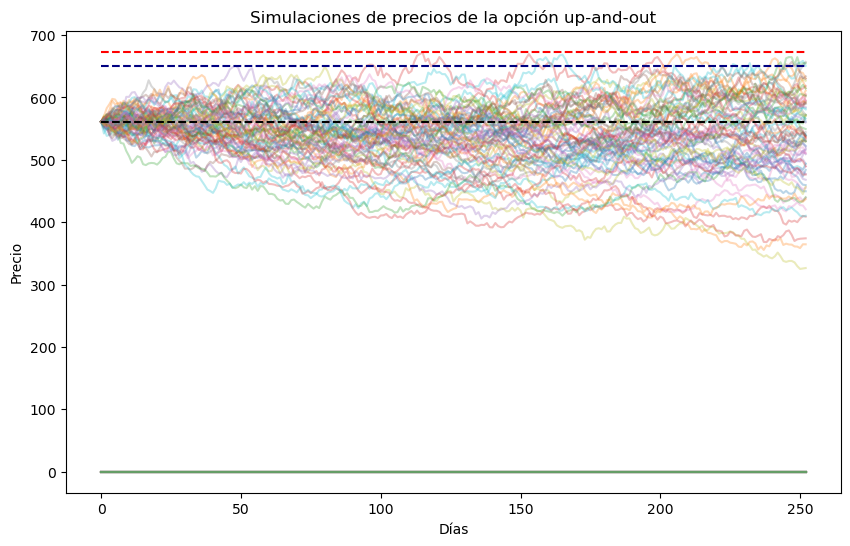

In [6]:
plt.figure(figsize=(10,6))
plt.plot(price_matrix.T, alpha=0.3)

plt.hlines(barrier_price, 0, T, linestyles='dashed', colors='red')
plt.hlines(S0, 0, T, linestyles='dashed', colors='black')
plt.hlines(K, 0, T, linestyles='dashed', colors='navy')


plt.title('Simulaciones de precios de la opción up-and-out')
plt.xlabel('Días')
plt.ylabel('Precio')
plt.show()

In [7]:
put_payoffs = np.maximum(K - price_matrix[:-1], 0)
put_payoffs

array([[ 88.87799072,  88.35420581,  79.60796227, ...,  78.66410116,
         77.17633194,  88.56568199],
       [ 88.87799072,  97.11439342,  84.11220489, ..., 291.41545224,
        285.38141325, 285.43813509],
       [650.        , 650.        , 650.        , ..., 650.        ,
        650.        , 650.        ],
       ...,
       [ 88.87799072,  92.83614331,  98.30206584, ...,  64.55436919,
         64.15060703,  65.5847563 ],
       [ 88.87799072,  83.4072981 ,  77.29758468, ..., 103.31586309,
        110.25834234, 105.48468785],
       [ 88.87799072,  94.36019296,  91.93732948, ..., 198.1155858 ,
        204.78281857, 193.06455044]])

In [8]:
put_value = np.exp(-r * T) * np.mean(put_payoffs)
put_value

0.0008659057667384496

## Código Final

In [9]:
def price_barrier_option(option_type: str, ticker: str, K: float | int, barrier_price: float | int, r: float) -> float:

    data = yf.download(ticker, start='2022-01-01', end='2025-03-15', progress=False)['Close']['SPY']
    daily_returns = data.pct_change().dropna()

    S0 = float(data.iloc[-1])
    sigma = daily_returns.std() * np.sqrt(252)
    T_days = 252
    T = 1  # años
    dt = T / T_days
    num_simulations = 10000

    Z = np.random.normal(0, 1, (num_simulations, T_days))
    payoffs = np.zeros(num_simulations)

    for i in range(num_simulations):
        path = [S0]
        barrier_breached = False
        for t in range(1, T_days + 1):
            St = path[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[i, t-1])
            path.append(St)

            if St > barrier_price:  # up-and-out
                barrier_breached = True
                break

        if not barrier_breached:
            ST = path[-1]
            if option_type == 'put':
                payoffs[i] = max(K - ST, 0)
            else:
                payoffs[i] = max(ST - K, 0)

    price = np.exp(-r * T) * np.mean(payoffs)
    return price

In [10]:
price_barrier_option( 'put', 'SPY', 620, 630, 0.1)

30.871954334041703